### Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

### Load and check data

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
train.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...",1131660440785968503_1472830385,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",377306020877927890_1472880147,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,1,1472880147
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...",3895546263509774583_1472865386,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,1,1472865386
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472881213,1,1472881213
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""continent"": ""Europe"", ""subContinent"": ""North...",27294437909732085_1472822600,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472822600,2,1472822600


##### Notice that there are some columns with format JSON, therefore we need to flatten them
##### Resource: https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields/notebook

In [6]:
import os
import json
from pandas.io.json import json_normalize

def load_df(csv_path='train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

print(os.listdir("../RevenuePrediction"))

['main.ipynb', '.DS_Store', 'test_v2.csv', 'sample_submission_v2.csv', 'test.csv', 'train-flattened.csv', 'test-flattened.csv', 'train_v2.csv', 'train.csv', '.ipynb_checkpoints', '.git', 'sample_submission.csv']


In [11]:
%%time
df_small = load_df(nrows=20000)

Loaded train.csv. Shape: (20000, 54)
CPU times: user 2.66 s, sys: 240 ms, total: 2.9 s
Wall time: 2.94 s


In [7]:
%%time
df_train = load_df()
df_test = load_df("test.csv")

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)
CPU times: user 4min 42s, sys: 1min 38s, total: 6min 20s
Wall time: 6min 49s


In [8]:
%%time
df_train.to_csv("train-flattened.csv", index=False)
df_test.to_csv("test-flattened.csv", index=False)

CPU times: user 48.6 s, sys: 11.2 s, total: 59.8 s
Wall time: 1min 6s


In [9]:
df_train.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
channelGrouping                                      903653 non-null object
date                                                 903653 non-null int64
fullVisitorId                                        903653 non-null object
sessionId                                            903653 non-null object
socialEngagementType                                 903653 non-null object
visitId                                              903653 non-null int64
visitNumber                                          903653 non-null int64
visitStartTime                                       903653 non-null int64
device.browser                                       903653 non-null object
device.browserSize                                   903653 non-null object
device.browserVersion                                903653 non-null object
device.deviceCategory                                9036

#### As We are predicting the natural log of the sum of all transactions per user, we first sum up the total transaction for each user

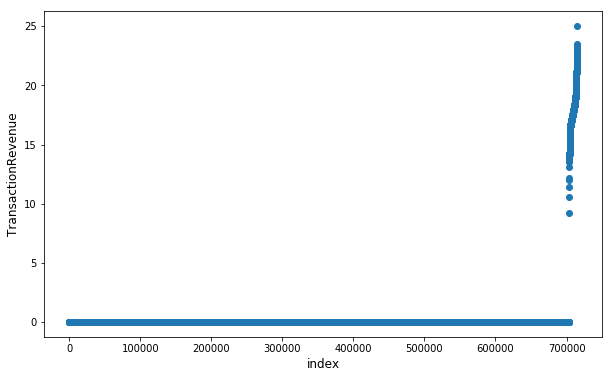

In [11]:
df_train['totals.transactionRevenue'] = df_train['totals.transactionRevenue'].astype('float')
grouped = df_train.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

plt.figure(figsize=(10,6))
plt.scatter(range(grouped.shape[0]), np.sort(np.log1p(grouped["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

<h4 style="color:red">This graph confirms the 80/20 rule that for many businesses–only a small percentage of customers produce most of the revenue.</h4>

<h4>More clear if shown in ratio:</h4>

In [12]:
count = (df_train["totals.transactionRevenue"]>0).sum()
count_unique = (grouped["totals.transactionRevenue"]>0).sum()
print ("Number of entries with none zero revenue: ", count)
print ("Ratio between non zero entries and total entries: ", count/df_train.shape[0])
print ('-'*10)
print ("Number of unqiue customers with none zero revenue: ", count_unique)
print ("Ratio between non zero unique customers and total entries: ", count_unique/df_train.shape[0])

Number of entries with none zero revenue:  11515
Ratio between non zero entries and total entries:  0.0127427231470487
----------
Number of unqiue customers with none zero revenue:  9996
Ratio between non zero unique customers and total entries:  0.011061768178714617


In [25]:
# Fill empty and NaNs values with NaN
# dataset = df_train.fillna(np.nan)

# Check for Null values
# dataset.isnull().sum()

In [13]:
non_unique = [c for c in df_train.columns if df_train[c].nunique(dropna=False)==1]
non_unique

['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

<h4>There are plenty of columns with constant value for every entry, we can simply drop those features since they make no influence to our outcome.</h4>

In [14]:
df_train[non_unique]

,socialEngagementType,device.browserSize,device.browserVersion,device.flashVersion,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.cityId,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,trafficSource.adwordsClickInfo.criteriaParameters
0,Not Socially Engaged,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,not available in demo dataset
1,Not Socially Engaged,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,not available in demo dataset
2,Not Socially Engaged,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,not available in demo dataset
3,Not Socially Engaged,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,not available in demo dataset
4,Not Socially Engaged,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,not available in demo dataset
5,Not Socially Engaged,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,not available in demo dataset
6,Not Socially Engaged,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not ava

In [15]:
df_train.shape[1]

55

In [16]:
df_train = df_train.drop(non_unique, axis=1)

In [17]:
df_train.shape[1]

36

In [155]:
# df_train.info()

<h2>Feature Analysis</h2>

<h5>We are going to draw some graphs to visualize the relation between feature and revenue.</h5>

<h3>Device</h3>

<h4 style="color:blue">Device Browser</h4>

In [41]:
# df_train['device.browser']

In [19]:
df_train['device.browser'].unique()

array(['Chrome', 'Firefox', 'UC Browser', 'Internet Explorer', 'Safari',
       'Edge', 'Opera Mini', 'Opera', 'BlackBerry', 'Safari (in-app)',
       'Coc Coc', 'Mozilla Compatible Agent', 'ADM', 'MRCHROME',
       'Amazon Silk', 'YaBrowser', 'Android Webview', 'Puffin',
       'Nokia Browser', 'Maxthon', 'Nintendo Browser', 'Android Browser',
       'Lunascape', 'IE with Chrome Frame', 'ThumbSniper',
       'LYF_LS_4002_12', 'Mozilla', 'osee2unifiedRelease', 'NokiaE52-1',
       'Iron', '[Use default User-agent string] LIVRENPOCHE', '(not set)',
       'LYF_LS_4002_11', 'M5', 'Android Runtime', 'Apple-iPhone7C2',
       'SeaMonkey', 'Konqueror', 'Seznam', 'Changa 99695759', 'no-ua',
       'MQQBrowser', 'Nichrome', 'HTC802t_TD', 'DASH_JR_3G', 'DoCoMo',
       'subjectAgent: NoticiasBoom', 'YE', 'User Agent', '0',
       'Hisense M20-M_LTE', 'Reddit', 'TCL P500M', 'CSM Click'],
      dtype=object)

In [20]:
len(df_train['device.browser'].unique())

54

In [30]:
df_train['device.browser'].value_counts()

Chrome                                         620364
Safari                                         182245
Firefox                                         37069
Internet Explorer                               19375
Edge                                            10205
Android Webview                                  7865
Safari (in-app)                                  6850
Opera Mini                                       6139
Opera                                            5643
UC Browser                                       2427
YaBrowser                                        2096
Coc Coc                                           727
Amazon Silk                                       561
Android Browser                                   553
Mozilla Compatible Agent                          374
MRCHROME                                          263
Maxthon                                           246
BlackBerry                                        184
Nintendo Browser            

In [194]:
browser_group = df_train.groupby('device.browser')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
browser_group.columns = ["number of visitors", "count of non-zero revenue", "mean"]
browser_group = browser_group.sort_values(by="number of visitors", ascending=False)
browser_group.head(10)

,number of visitors,count of non-zero revenue,mean
device.browser,,,
Chrome,620364,10353,1.335946e+08
Safari,182245,780,6.717626e+07
Firefox,37069,191,4.676247e+08
Internet Explorer,19375,109,7.573899e+07
Edge,10205,58,1.117753e+08
Android Webview,7865,6,1.914167e+07
Safari (in-app),6850,12,1.281417e+07
Opera Mini,6139,0,NaN
Opera,5643,5,4.307000e+07


In [195]:
browser_group['device browser'] = browser_group.index

In [196]:
browser_group.head()

,number of visitors,count of non-zero revenue,mean,device browser
device.browser,,,,
Chrome,620364,10353,1.335946e+08,Chrome
Safari,182245,780,6.717626e+07,Safari
Firefox,37069,191,4.676247e+08,Firefox
Internet Explorer,19375,109,7.573899e+07,Internet Explorer
Edge,10205,58,1.117753e+08,Edge


In [64]:
# import warnings
# warnings.filterwarnings('ignore')

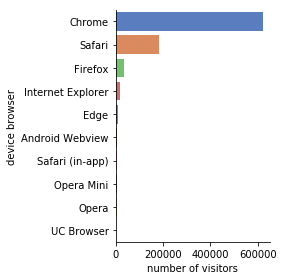

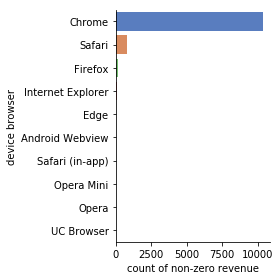

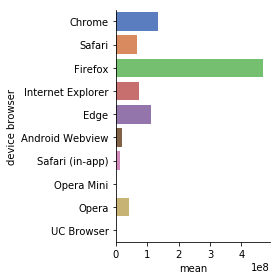

In [197]:
sns.factorplot(y="device browser",x="number of visitors",data=browser_group.head(10),kind="bar",size=4,palette="muted")
g1.despine(left=True)
g1 = g1.set_ylabels("device browser")

sns.factorplot(y="device browser",x="count of non-zero revenue",data=browser_group.head(10),kind="bar",size=4,palette="muted")
g2.despine(left=True)
g2 = g2.set_ylabels("device browser")

sns.factorplot(y="device browser",x="mean",data=browser_group.head(10),kind="bar",size=4,palette="muted")
g3.despine(left=True)
g3 = g3.set_ylabels("device browser")


<h4 style="color:blue">Device Category</h4>

In [49]:
df_train['device.deviceCategory'].value_counts()

desktop    664479
mobile     208725
tablet      30449
Name: device.deviceCategory, dtype: int64

In [198]:
device_group = df_train.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
device_group.columns = ["number of visitors", "count of non-zero revenue", "mean"]
device_group['device category'] = device_group.index
device_group = device_group.sort_values(by="number of visitors", ascending=False)

In [199]:
device_group

,number of visitors,count of non-zero revenue,mean,device category
device.deviceCategory,,,,
desktop,664479,10495,1.411019e+08,desktop
mobile,208725,852,5.843405e+07,mobile
tablet,30449,168,5.607940e+07,tablet


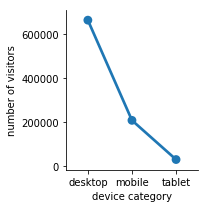

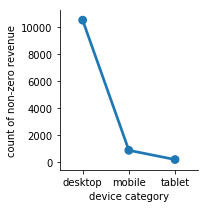

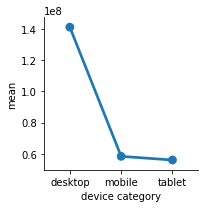

In [200]:
sns.factorplot(x="device category",y="number of visitors",data=device_group,size=3)
g = g.set_ylabels("number of visitors")

sns.factorplot(x="device category",y="count of non-zero revenue",data=device_group,size=3)
g = g.set_ylabels("count of non-zero revenue")

sns.factorplot(x="device category",y="mean",data=device_group,size=3)
g = g.set_ylabels("mean")

<h4 style="color:blue">isMobile</h4>

In [201]:
isMobile_group = df_train.groupby('device.isMobile')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
isMobile_group.columns = ["number of visitors", "count of non-zero revenue", "mean"]
isMobile_group['isMobile'] = isMobile_group.index
isMobile_group = isMobile_group.sort_values(by="number of visitors", ascending=False)

In [202]:
isMobile_group

,number of visitors,count of non-zero revenue,mean,isMobile
device.isMobile,,,,
False,664530,10495,1.410988e+08,False
True,239123,1020,5.807805e+07,True


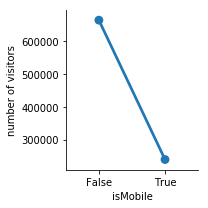

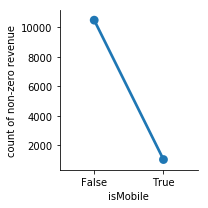

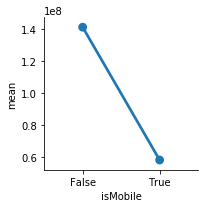

In [203]:
sns.factorplot(x="isMobile",y="number of visitors",data=isMobile_group,size=3)
g = g.set_ylabels("number of visitors")

sns.factorplot(x="isMobile",y="count of non-zero revenue",data=isMobile_group,size=3)
g = g.set_ylabels("count of non-zero revenue")

sns.factorplot(x="isMobile",y="mean",data=isMobile_group,size=3)
g = g.set_ylabels("mean")

<h4 style="color:blue">Operating System</h4>

In [204]:
OS_group = df_train.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
OS_group.columns = ["number of visitors", "count of non-zero revenue", "mean"]
OS_group['OS'] = OS_group.index
OS_group = OS_group.sort_values(by="number of visitors", ascending=False)

In [205]:
OS_group

,number of visitors,count of non-zero revenue,mean,OS
device.operatingSystem,,,,
Windows,350072,2309,1.720713e+08,Windows
Macintosh,253938,6426,1.332673e+08,Macintosh
Android,123892,467,7.781859e+07,Android
iOS,107665,536,4.135616e+07,iOS
Linux,35034,782,5.615141e+07,Linux
Chrome OS,26337,994,1.850480e+08,Chrome OS
(not set),4695,0,NaN,(not set)
Windows Phone,1216,1,2.640000e+07,Windows Phone
Samsung,280,0,NaN,Samsung


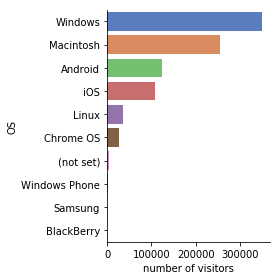

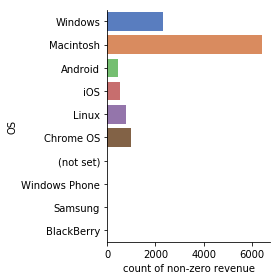

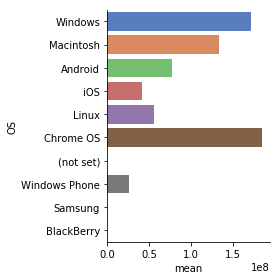

In [206]:
sns.factorplot(y="OS",x="number of visitors",data=OS_group.head(10),kind="bar",size=4,palette="muted")
g1.despine(left=True)
g1 = g1.set_ylabels("OS")

sns.factorplot(y="OS",x="count of non-zero revenue",data=OS_group.head(10),kind="bar",size=4,palette="muted")
g2.despine(left=True)
g2 = g2.set_ylabels("OS")

sns.factorplot(y="OS",x="mean",data=OS_group.head(10),kind="bar",size=4,palette="muted")
g3.despine(left=True)
g3 = g3.set_ylabels("OS")

<h4 style="color:red">Inference from device:</h4>

<p>1. device browser: count and non-zero are similar, but mean varies, however, firefox has much less user</p>
<p>2. device category: three graphs are coherent, desktop > mobile > tablet</p>
<p>3. isMobile: clearly, non-mobile users > mobile users</p>
<p>4. operating system: windows counts for most count, Macintosh counts for most non-zero, Chrome wins in mean</p>

<h3>Date</h3>

In [156]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 36 columns):
channelGrouping                                 903653 non-null object
date                                            903653 non-null int64
fullVisitorId                                   903653 non-null object
sessionId                                       903653 non-null object
visitId                                         903653 non-null int64
visitNumber                                     903653 non-null int64
visitStartTime                                  903653 non-null int64
device.browser                                  903653 non-null object
device.deviceCategory                           903653 non-null object
device.isMobile                                 903653 non-null bool
device.operatingSystem                          903653 non-null object
geoNetwork.city                                 903653 non-null object
geoNetwork.continent                       

In [186]:
import datetime
df_train['date'] = df_train['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
date_group = df_train.groupby('date')['totals.transactionRevenue'].agg(['size', 'count'])
date_group.columns = ["number of visitors", "count of non-zero revenue"]
date_group['date'] = date_group.index

ValueError: invalid literal for int() with base 10: '9-02'

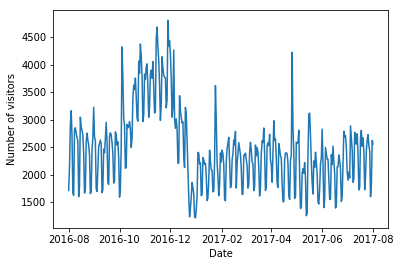

In [193]:
plt.xlabel('Date')
plt.ylabel('Number of visitors')
plt.plot(date_group['date'],date_group['number of visitors'])

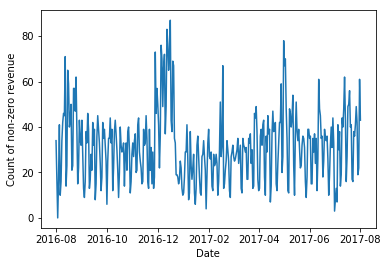

In [192]:
plt.xlabel('Date')
plt.ylabel('Count of non-zero revenue')
plt.plot(date_group['date'],date_group['count of non-zero revenue'])

<h4 style="color:red">Inference from date:</h4>

<p>1. The range of date from the training set is August 01 2016 to July 31 2017.</p>
<p>2. Increase in number of visitor in 2016.8 and 2016.10 did not incur a incrase in the revenue.</p>

In [207]:
df_test['date'] = df_test['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
test_date = df_test.groupby('date')['fullVisitorId'].size()

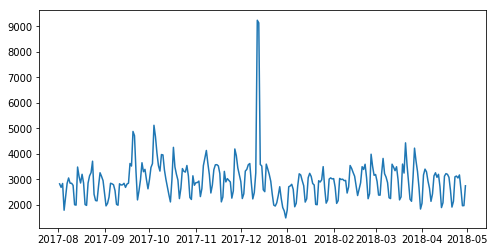

In [224]:
plt.figure(figsize=(8,4))
plt.plot(test_date)

<h5 style="color:red">Notice that the datetime from test set hav